# Schedule TPC-DS 1 Feature Selection

This notebook is dedicated to dataset profiling. In this notebook, feature selection techniques will be implemented so as to categorize which features belay the most information to address the problem at hand - Workload Prediction. Due to the vast feature space which have been gathered during a workload's execution, manual techniques at determining which are most detrimental is not sufficient. 

Therefore the following work puts emphasis on automated techniques so as to determine out of the vast feature space which are most important to base future models upon. 

In [138]:
#
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from operator import itemgetter

In [139]:
tpcds='TPCDS1' # Schema upon which to operate test
debug_mode=True # Determines whether to plot graphs or not, useful for development purposes 
low_quartile_limit = .01 # Lower Quartile threshold to detect outliers
upper_quartile_limit = .99 # Upper Quartile threshold to detect outliers
lag=0 # Time Series shift / Lag Step. Each lag value equates to 1 minute
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (26,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset Description

The correlation of resources consumed (y) per snapshot (X) define our feature space. Since the objective here is to attempt to predict what resources will be incurred ahead of time, the problem can be defined as a number of questions:

* Q: What resources can I predict to be in usage at point N in time?
* Q: What resources should I be predicting that accurately portray a schedule's workload?
* Q: What knowledge/data do I have ahead of time which I can use to base my predictions off?

Due to the vast feature space in the available metrics monitored and captured during a workload's execution, it is important to rank which attribute is most beneficial than others. Additionally, it is important to analyze such features individually, and considerate of other features in two types of analysis:

* Univariate Analysis
* Multivariate Analysis

Furthermore, multiple types of feature ranking / analysis techniques ara available, amongst which will be considered:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Data Preprocessing

We apply a number of preprocessing techniques to the presented dataframes, particularly to normalize and/or scale feature vectors into a more suitable representation for downstream estimators:

Relative Links:
* http://scikit-learn.org/stable/modules/preprocessing.html
* https://machinelearningmastery.com/improve-model-accuracy-with-data-pre-processing/
* https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

### Table Pivots

To better handle the following table, a number of table pivots are made on tables:
* rep_hist_sysmetric_summary
* rep_hist_sysstat

In [140]:
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
print(rep_hist_sysmetric_summary_df.columns)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSMETRIC Shape: " + str(rep_hist_sysmetric_summary_df.shape))
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
print(rep_hist_sysstat_df.columns)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSSTAT_DF Shape: " + str(rep_hist_sysstat_df.shape))
#
# Refreshing columns with pivoted columns
def convert_list_to_upper(col_list):
    """
    Takes a string and converts elements to upper
    """
    upper_col_list = []
    for col in col_list:
        upper_col_list.append(col.upper())
    return upper_col_list
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
rep_hist_snapshot_headers = rep_hist_snapshot_df.columns
rep_hist_sysmetric_summary_headers = rep_hist_sysmetric_summary_df.columns
rep_hist_sysstat_headers = rep_hist_sysstat_df.columns
rep_vsql_plan_headers = rep_vsql_plan_df.columns
#
# DF Shape
print('\n\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))
print('Table [REP_VSQL_PLAN] - ' + str(rep_vsql_plan_df.shape))

Index(['SNAP_ID', 'Active Parallel Sessions', 'Active Serial Sessions',
       'Average Active Sessions',
       'Average Synchronous Single-Block Read Latency',
       'Background CPU Usage Per Sec', 'Background Checkpoints Per Sec',
       'Background Time Per Sec', 'Branch Node Splits Per Sec',
       'Branch Node Splits Per Txn',
       ...
       'User Commits Percentage', 'User Limit %',
       'User Rollback Undo Records Applied Per Txn',
       'User Rollback UndoRec Applied Per Sec', 'User Rollbacks Per Sec',
       'User Rollbacks Percentage', 'User Transaction Per Sec',
       'VM in bytes Per Sec', 'VM out bytes Per Sec',
       'Workload Capture and Replay status'],
      dtype='object', name='METRIC_NAME', length=162)
REP_HIST_SYSMETRIC Shape: (172, 162)
Index(['SNAP_ID', 'ADG global flush', 'ADG parselock X get attempts',
       'ADG parselock X get successes', 'BA au bytes allocated',
       'BA bytes for file maps', 'BA bytes read from disk',
       'BA bytes read from

### Checking for NaN Values

Checking dataframes for potential missing values/data:

In [141]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print("Table REP_HIST_SNAPSHOT: " + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

Table REP_HIST_SNAPSHOT: ['OPTIMIZER_COST', 'MODULE', 'ACTION', 'SQL_PROFILE', 'BIND_DATA', 'FLAG']


Table REP_HIST_SYSMETRIC_SUMMARY: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'DDL STATEMENTS PARALLELIZED PER SEC', 'DML STATEMENTS PARALLELIZED PER SEC', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'QUERIES PARALLELIZED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED', 'TOTAL PGA USED BY SQL WORKAREAS', 'VM IN BYTES PER SEC', 'VM OUT BYTES PER SEC', 'WORKLOAD CAPTURE AND REPLAY STATUS']


Table REP_HIST_SYSSTAT: ['FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM SPACE SMU CREATIONS COMMITTED', 'PARALLEL OPERATIONS DOWNGRADED TO SERIAL']


Table 

### Checking for Negative Values

A function which retrieves a count per column for nay negative values it might contain

In [142]:
def count_neg_df(df, headers):
    """
    Return columns with respective negative value count
    """
    neg_list = []
    for head in headers:
        count = 0
        try:
            count = sum(n < 0 for n in df[head].values.flatten())
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
        if count > 0:
            neg_list.append([head,count])
    return neg_list
#
def fill_neg(df, headers):
    """
    Sets any data anomilies resulting in negative values to 0
    
    :param headers: list as follows eg: ['column_name', 'negative_count']
    """
    for head in headers:
        try:
            df[df[head[0]] < 0] = 0
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
    return df
#
# Check For Negative Values within dataframes
print('---------------WITH NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
# Replace Negative Values with a minimal threshold of 0
rep_hist_snapshot_df = fill_neg(df=rep_hist_snapshot_df,headers=count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers))
rep_hist_sysmetric_summary_df = fill_neg(df=rep_hist_sysmetric_summary_df,headers=count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers))
rep_hist_sysstat_df = fill_neg(df=rep_hist_sysstat_df,headers=count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers))
rep_vsql_plan_df = fill_neg(df=rep_vsql_plan_df,headers=count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers))
#
# Check For Negative Values within dataframes
print('\n\n---------------WITHOUT NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")

---------------WITH NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: [['IO_OFFLOAD_RETURN_BYTES_TOTAL', 11], ['IO_OFFLOAD_RETURN_BYTES_DELTA', 6]]


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




---------------WITHOUT NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: []


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




## Visualizing Feature Distribution & Skewness

In order to decide between a normalization strategy, it is important to understand the underlying data spread. Understanding of dataset mean, variance, skewness on a per column/feature basis helps determine whether a standardization or normalization strategy should be utilized on the datasets.

### Plotting Data Distribution

To better decide which normalization technique ought to be utilized for the technique at hand, a number of feature columns will be plotted as histograms to better convey the distribution spread.

In [143]:
def plot_hist(df=None, tpc_type=None, table=None, feature_column=None, bin_size=10):
    """
    Plots histogram distribution
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(float)
        df[feature_column] = df[feature_column].astype(float)
        #
        max_val = df[feature_column].max()
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df[feature_column].hist(bins=10,figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('Bin Ranges Of ' + str(int(max_val/bin_size)))
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_scatter(df=None, tpc_type=None, table=None, feature_column=None):
    """
    Plots scatter plots vs SNAP_ID
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(int)
        df[feature_column] = df[feature_column].astype(int)
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df.plot.scatter(x='SNAP_ID',
                        y=feature_column,
                        figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('SNAP ID')
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_boxplot(df=None, tpc_type=None, table=None, feature_columns=None):
    """
    Plots quartile plots to estimate mean and sigma (std dev)
    """
    #
    try:
        for feature_column in feature_columns:
            df[feature_column] = df[feature_column].astype(int)
        df.boxplot(column=feature_columns, figsize=(12,8), grid=True)
        plt.title(tpc_type + ' ' + str(feature_columns))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
if debug_mode is False:
    #
    # Plotting Histograms of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysstat_df, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots of data distribution
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_headers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Outlier Handling

https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

As can be appreciated from the previous plots, data is heavily skewed on particular (smallest) bins. This skew in the plotted histograms is a result of data point outliers - these need to be evaluated and removed if neccessary.

Following the 3 Standard Deviation Rule, we can categorize our dataset into subsets consisting of the following ranges:
* 0     - 68.27%
* 68.28 - 95.45%
* 95.46 - 99.73%
* 99.74 - 100%

It should be mentioned, that given the time series nature of the dataset, it is not a safe assumption to ignore outliers. By training respective models on outlier insensitive dataset, we would invite a potential problem, which risks blinding any models we train to future predicted spikes of activity.

In [144]:
def get_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            series_row = (df[df[header] > q].index-1)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            q = df[header].quantile(low_quartile_limit)
            series_row = (df[df[header] < q].index-1)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
        except Exception as e:
            print(str(e))
    #
    unique_ids = []
    unique_outlier_rows = []
    #
    for col, rowid in outlier_rows:
        if rowid not in unique_ids:
            unique_outlier_rows.append([col,rowid])
            unique_ids.append(rowid)
    return unique_outlier_rows
#
def remove_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Remove rows which are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    length_before = len(df)
    outliers_index = []
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] > q].index)))
            q = df[header].quantile(low_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] < q].index)))
        except Exception as e:
            print(str(e))
    #flat_outliers_index = [item for sublist in l for item in outliers_index]
    flat_outliers_index = [item for sublist in outliers_index for item in sublist]
    outliers_index = list(set(flat_outliers_index))
    df = df.drop(outliers_index)
    return df
#
# Defining which columns will be exposed to outliers
# rep_hist_snapshot_header_outliers = rep_hist_snapshot_headers
rep_hist_snapshot_header_outliers = ['PLAN_HASH_VALUE',
                                    'OPTIMIZER_COST',
                                    'OPTIMIZER_ENV_HASH_VALUE',
                                    'SHARABLE_MEM',
                                    'LOADED_VERSIONS',
                                    'VERSION_COUNT',
                                    'FORCE_MATCHING_SIGNATURE',
                                    'PARSING_SCHEMA_ID',
                                    'PARSING_USER_ID',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'CLWAIT_TOTAL',
                                    'CLWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'JAVEXEC_TIME_TOTAL',
                                    'JAVEXEC_TIME_DELTA',
                                    'IO_OFFLOAD_ELIG_BYTES_TOTAL',
                                    'IO_OFFLOAD_ELIG_BYTES_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'OPTIMIZED_PHYSICAL_READS_TOTAL',
                                    'OPTIMIZED_PHYSICAL_READS_DELTA',
                                    'CELL_UNCOMPRESSED_BYTES_TOTAL',
                                    'CELL_UNCOMPRESSED_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']
rep_hist_sysmetric_summary_header_outliers = rep_hist_sysmetric_summary_headers
rep_hist_sysstat_header_outliers = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
rep_vsql_plan_headers_outliers = ['PLAN_HASH_VALUE',
                                  'FULL_PLAN_HASH_VALUE',
                                  'CHILD_NUMBER',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME',
                                  'CON_ID']
#
#Printing outliers to screen
outliers = get_outliers(df=rep_hist_snapshot_df,
                           headers=rep_hist_snapshot_header_outliers,
                           upper_quartile_limit=upper_quartile_limit,
                           low_quartile_limit=low_quartile_limit)
for header, loc in outliers:
    print(str(loc+2) + " - " + str(rep_hist_snapshot_df.iloc[loc]['SQL_ID']) + " - " + str(header) + " - " + str(rep_hist_snapshot_df.iloc[loc][header]))
#
# Printing dataframe before adjustments
print('\n\nDATAFRAMES WITH OUTLIERS')
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)
print(rep_vsql_plan_df.shape)
print('----------------------------')
#
#Printing outliers to screen
rep_hist_snapshot_df_outliers = get_outliers(df=rep_hist_snapshot_df, 
                                             headers=rep_hist_snapshot_header_outliers,
                                             upper_quartile_limit=upper_quartile_limit,
                                             low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_outliers = get_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_outliers = get_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit= upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_outliers = get_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nOUTLIERS')
print(len(rep_hist_snapshot_df_outliers))
print(len(rep_hist_sysmetric_summary_df_outliers))
print(len(rep_hist_sysstat_df_outliers))
print(len(rep_vsql_plan_df_outliers))
print('----------------------------')
#
# Dropping Outliers
rep_hist_snapshot_df_pruned = remove_outliers(df=rep_hist_snapshot_df, headers=rep_hist_snapshot_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_pruned = remove_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_pruned = remove_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_pruned = remove_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nDATAFRAMES WITHOUT OUTLIERS')
print(rep_hist_snapshot_df_pruned.shape)
print(rep_hist_sysmetric_summary_df_pruned.shape)
print(rep_hist_sysstat_df_pruned.shape)
print(rep_vsql_plan_df_pruned.shape)
#
print('\n\nFirst 20 record sample before outliers:')
print(rep_hist_snapshot_df.iloc[0:20]['SQL_ID'])
print('---------------------------------------')
print('First 20 record sample after outliers:')
print(rep_hist_snapshot_df_pruned.iloc[0:20]['SQL_ID'])
print('---------------------------------------')

4 - 0kcbwucxmazcp - PLAN_HASH_VALUE - 0.0
70 - 06g9mhm5ba7tt - PLAN_HASH_VALUE - 0.0
129 - 06g9mhm5ba7tt - PLAN_HASH_VALUE - 0.0
196 - 0s0s74y04cdmn - PLAN_HASH_VALUE - 2213556405.0
261 - 0s0s74y04cdmn - PLAN_HASH_VALUE - 2213556405.0
325 - 0kkhhb2w93cx0 - PLAN_HASH_VALUE - 2170058777.0
394 - 0s0s74y04cdmn - PLAN_HASH_VALUE - 2213556405.0
544 - 4tj4q758n8cv9 - PLAN_HASH_VALUE - 896925451.0
556 - 8swypbbr0m372 - PLAN_HASH_VALUE - 570326988.0
611 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
748 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
857 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1000 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1127 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1160 - 95y5r5ksf94b1 - PLAN_HASH_VALUE - 3262039238.0
1319 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1354 - 97pbnmc9h3ny4 - PLAN_HASH_VALUE - 1577381241.0
1463 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1589 - 5vg12vrnu4ac0 - PLAN_HASH_VALUE - 1553718629.0
1726 - 8zc85a8249x

10004 - cyn1rqak0v9hs - OPTIMIZER_ENV_HASH_VALUE - 258087403.0
10041 - d7w1dugmzb9n9 - OPTIMIZER_ENV_HASH_VALUE - 3207304630.0
10049 - f61hud2wa61nu - OPTIMIZER_ENV_HASH_VALUE - 258087403.0
13110 - 38243c4tqrkxm - OPTIMIZER_ENV_HASH_VALUE - 2537082850.0
13196 - b09qw4b47vdwz - OPTIMIZER_ENV_HASH_VALUE - 1993609079.0
13255 - d7w1dugmzb9n9 - OPTIMIZER_ENV_HASH_VALUE - 3207304630.0
13256 - dbn23msf2gqsh - OPTIMIZER_ENV_HASH_VALUE - 3831438878.0
13264 - dm7wjadqjyqna - OPTIMIZER_ENV_HASH_VALUE - 3207304630.0
16733 - 38243c4tqrkxm - OPTIMIZER_ENV_HASH_VALUE - 2537082850.0
16737 - 3xpr5jgcmcz8n - OPTIMIZER_ENV_HASH_VALUE - 258087403.0
16744 - 6brp00b214b53 - OPTIMIZER_ENV_HASH_VALUE - 258087403.0
16773 - d9vwwf91fgtny - OPTIMIZER_ENV_HASH_VALUE - 258087403.0
20121 - 975713susc49j - OPTIMIZER_ENV_HASH_VALUE - 1993609079.0
20215 - 1mvbtvbqt4z4p - OPTIMIZER_ENV_HASH_VALUE - 3316887484.0
20220 - 38243c4tqrkxm - OPTIMIZER_ENV_HASH_VALUE - 2537082850.0
20280 - 8k0qd372mh9td - OPTIMIZER_ENV_HASH_VA

19894 - fg4skgcja2cyj - END_OF_FETCH_COUNT_DELTA - 5.0
19896 - fhf8upax5cxsz - END_OF_FETCH_COUNT_DELTA - 5.0
20054 - a6r5q9yqaqabs - END_OF_FETCH_COUNT_DELTA - 45.0
20069 - dfbut3u7yv4nr - END_OF_FETCH_COUNT_DELTA - 6.0
20073 - fgrdzs7rhvtd9 - END_OF_FETCH_COUNT_DELTA - 17951.0
20077 - gdhz78y24tvnz - END_OF_FETCH_COUNT_DELTA - 30.0
20166 - 7jpt4cpfvcy1k - END_OF_FETCH_COUNT_DELTA - 356.0
20168 - 86kwhy1f0bttn - END_OF_FETCH_COUNT_DELTA - 1203.0
20191 - fhf8upax5cxsz - END_OF_FETCH_COUNT_DELTA - 5.0
707 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
803 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
938 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1079 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1203 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1262 - dfffkcnqfystw - SORTS_TOTAL - 4939.0
1407 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1534 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1677 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
1742 - f0f68t7c4105q - SORTS_TOTAL - 0.0
1805 - dvpfc386d6dmm - SORTS_TOTAL - 0.0
2515 - dyk4dprp70d74 - SORTS_TOTAL - 0.0
25

17045 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61265820.0
17453 - 2046z7kdh823h - BUFFER_GETS_TOTAL - 925697.0
17454 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61268718.0
17455 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61265820.0
17750 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 113721.0
17751 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 36707416.0
17752 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61268718.0
17753 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61265820.0
18020 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 113721.0
18021 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 56061518.0
18022 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61268718.0
18023 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61265820.0
18330 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 113721.0
18331 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 58383780.0
18332 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61268718.0
18333 - 2j5bk3tn2zt0g - BUFFER_GETS_TOTAL - 61265820.0
18907 - 01tp87bk1t2zv - BUFFER_GETS_TOTAL - 2578019.0
18927 - 0y080mnfaqk3u - BUFFER_GETS_TOTAL - 623629.0
18950 - 2j5bk3tn2zt0g

6027 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
6219 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
7238 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
7321 - 4r62dbqxw2r10 - PLSEXEC_TIME_TOTAL - 0.0
7651 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
7847 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
8071 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
8425 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
8653 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
8848 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
9074 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
10110 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
10204 - 4r62dbqxw2r10 - PLSEXEC_TIME_TOTAL - 0.0
10317 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
10583 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
10744 - fur78fafyqrkn - PLSEXEC_TIME_TOTAL - 0.0
10815 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
11000 - fur78fafyqrkn - PLSEXEC_TIME_TOTAL - 0.0
11072 - 5pxcsstbnzj04 - PLSEXEC_TIME_TOTAL - 0.0
11262 - fur78fafyqrkn - PLSEXEC_TIME_TOTAL - 0.0
11471 - 5pxcsstbnzj04 - PLSEXEC



DATAFRAMES WITHOUT OUTLIERS
(16705, 88)
(77, 162)
(154, 1179)
(195407, 42)


First 20 record sample before outliers:
0     04kug40zbu4dm
1     06g9mhm5ba7tt
2     0kcbwucxmazcp
3     0vcs754gpmxrc
4     1p5grz1gs7fjq
5     1vpham7m95msd
6     1wz811srf8xh8
7     2tkw12w5k68vd
8     360qzju916m57
9     38243c4tqrkxm
10    3bfw7718musbv
11    3kywng531fcxu
12    3m8smr0v7v1m6
13    3ru3r9twxsazy
14    3un99a0zwp4vd
15    3y6pgnk2ubw7g
16    45bv8pz1znkhr
17    45h233mys5n3s
18    45zq5xs59sjsj
19    4b4wp0a8dvkf0
Name: SQL_ID, dtype: object
---------------------------------------
First 20 record sample after outliers:
0     04kug40zbu4dm
2     0kcbwucxmazcp
4     1p5grz1gs7fjq
6     1wz811srf8xh8
7     2tkw12w5k68vd
8     360qzju916m57
9     38243c4tqrkxm
10    3bfw7718musbv
11    3kywng531fcxu
12    3m8smr0v7v1m6
13    3ru3r9twxsazy
14    3un99a0zwp4vd
15    3y6pgnk2ubw7g
16    45bv8pz1znkhr
17    45h233mys5n3s
18    45zq5xs59sjsj
19    4b4wp0a8dvkf0
20    4ctsftavdddk7
21    4cv3nc10

### Plotting data distribution without outliers

Plotting metrics against SNAP_ID, without outliers.

In [145]:
if debug_mode is False:
    #
    # Plotting Histograms without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots without Outliers
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_header_outliers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Column Seperation (X,y)

This section separates the dataset into feature vectors X and target labels y

In [146]:
y_rep_hist_snapshot_df_pruned = rep_hist_snapshot_df_pruned[['SNAP_ID']]
y_rep_hist_sysmetric_summary_df_pruned = rep_hist_sysmetric_summary_df_pruned[['SNAP_ID']]
y_rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned[['SNAP_ID']]

### Dropping Redundant Columns

Dropping redundant columns which are not detrimental to the task at hand (NB: This is only the first steps towards feature selection. This step ensures that specific columns which are SURELY not useful are dropped ahead of time).

http://benalexkeen.com/feature-scaling-with-scikit-learn/

Based on the above plots, one can argue that the data distribution is uneven, and does not correlate to any particular pattern. A normalization approach (MinMaxScaling and/or RobustScaling) to the presented dataset is a more likely candidate than standardizing of the presented dataset. 

Reasons behind normalizing the dataset rather than standardizing, is due to the vast standard deviations from the mean for several feature columns.

In [147]:
retain_headers_rep_hist_snapshot = ['PLAN_HASH_VALUE',
                                    'OPTIMIZER_COST',
                                    'OPTIMIZER_ENV_HASH_VALUE',
                                    'SHARABLE_MEM',
                                    'LOADED_VERSIONS',
                                    'VERSION_COUNT',
                                    'FORCE_MATCHING_SIGNATURE',
                                    'PARSING_SCHEMA_ID',
                                    'PARSING_USER_ID',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'CLWAIT_TOTAL',
                                    'CLWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'JAVEXEC_TIME_TOTAL',
                                    'JAVEXEC_TIME_DELTA',
                                    'IO_OFFLOAD_ELIG_BYTES_TOTAL',
                                    'IO_OFFLOAD_ELIG_BYTES_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'OPTIMIZED_PHYSICAL_READS_TOTAL',
                                    'OPTIMIZED_PHYSICAL_READS_DELTA',
                                    'CELL_UNCOMPRESSED_BYTES_TOTAL',
                                    'CELL_UNCOMPRESSED_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']
retain_headers_rep_hist_sysmetric_summary = rep_hist_sysmetric_summary_headers
retain_headers_rep_hist_sysstat = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
retain_headers_rep_vsql_plan = ['PLAN_HASH_VALUE',
                                  'FULL_PLAN_HASH_VALUE',
                                  'CHILD_NUMBER',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME',
                                  'CON_ID']
#
def retain_these_columns(dataframe, headers):
    """
    Drops all columns from dataframe except those passed in the header
    """
    return dataframe[headers]
#
shape = rep_hist_snapshot_df_pruned.shape
rep_hist_snapshot_df_pruned = retain_these_columns(dataframe=rep_hist_snapshot_df_pruned,headers=retain_headers_rep_hist_snapshot)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_snapshot_df_pruned.shape))
#
shape = rep_hist_sysmetric_summary_df_pruned.shape
rep_hist_sysmetric_summary_df_pruned = retain_these_columns(dataframe=rep_hist_sysmetric_summary_df_pruned,headers=retain_headers_rep_hist_sysmetric_summary)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysmetric_summary_df_pruned.shape))
#
shape = rep_hist_sysstat_df_pruned.shape
rep_hist_sysstat_df_pruned = retain_these_columns(dataframe=rep_hist_sysstat_df_pruned, headers=retain_headers_rep_hist_sysstat)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysstat_df_pruned.shape))
#
shape = rep_vsql_plan_df_pruned.shape
rep_vsql_plan_df_pruned = retain_these_columns(dataframe=rep_vsql_plan_df_pruned, headers=retain_headers_rep_vsql_plan)
print('Before: ' + str(shape) + '| After: ' + str(rep_vsql_plan_df_pruned.shape))

Before: (16705, 88)| After: (16705, 67)
Before: (77, 162)| After: (77, 162)
Before: (154, 1179)| After: (154, 1179)
Before: (195407, 42)| After: (195407, 15)


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset

In [148]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
shape = rep_hist_snapshot_df_pruned.shape
rep_hist_snapshot_df_pruned = series_to_supervised(data=rep_hist_snapshot_df_pruned,n_in=lag)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_snapshot_df_pruned.shape))
#
shape = rep_hist_sysmetric_summary_df_pruned.shape
rep_hist_sysmetric_summary_df_pruned = series_to_supervised(data=rep_hist_sysmetric_summary_df_pruned,n_in=lag)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysmetric_summary_df_pruned.shape))
#
shape = rep_hist_sysstat_df_pruned.shape
rep_hist_sysstat_df_pruned = series_to_supervised(data=rep_hist_sysstat_df_pruned,n_in=lag)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysstat_df_pruned.shape))
#
shape = rep_vsql_plan_df_pruned.shape
rep_vsql_plan_df_pruned = series_to_supervised(data=rep_vsql_plan_df_pruned,n_in=lag)
print('Before: ' + str(shape) + '| After: ' + str(rep_vsql_plan_df_pruned.shape))

Before: (16705, 67)| After: (16705, 67)
Before: (77, 162)| After: (77, 162)
Before: (154, 1179)| After: (154, 1179)
Before: (195407, 15)| After: (195407, 15)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [149]:
def robust_scaler(dataframe, headers):
    """
    Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
    normalization of values.
    """
    return preprocessing.robust_scale(dataframe)
#
def minmax_scaler(dataframe, headers):
    """
    Normalize df using min-max ranges for normalization method
    """
    return preprocessing.minmax_scale(dataframe)
#
def normalize(dataframe, headers):
    """
    The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features. 
    """
    return preprocessing.normalize(dataframe)
#
print('------------------BEFORE------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned.shape)
print('\n')
print(rep_hist_snapshot_df_pruned.head())
#
# ROBUST SCALER
# rep_hist_snapshot_df_pruned_norm = robust_scaler(dataframe=rep_hist_snapshot_df_pruned, 
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = robust_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# MINMAX SCALER
# rep_hist_snapshot_df_pruned_norm = minmax_scaler(dataframe=rep_hist_snapshot_df_pruned,
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = minmax_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# NORMALIZER
rep_hist_snapshot_df_pruned_norm = normalize(dataframe=rep_hist_snapshot_df_pruned, 
                                             headers=retain_headers_rep_hist_snapshot)
rep_hist_sysmetric_summary_df_pruned_norm = normalize(dataframe=rep_hist_sysmetric_summary_df_pruned,
                                                      headers=retain_headers_rep_hist_sysmetric_summary)
rep_hist_sysstat_df_pruned_norm = normalize(dataframe=rep_hist_sysstat_df_pruned,
                                            headers=retain_headers_rep_hist_sysstat)
rep_vsql_plan_df_pruned_norm = normalize(dataframe=rep_vsql_plan_df_pruned,
                                         headers=retain_headers_rep_vsql_plan)
#
print('\n\n------------------AFTER------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned_norm.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned_norm.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned_norm.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned_norm.shape)
print('\n\n')
print('REP_HIST_SNAPSHOT')
print(rep_hist_snapshot_df_pruned_norm[0])
print('\n\nREP_HIST_SYSMETRIC_SUMMARY')
print(rep_hist_sysmetric_summary_df_pruned_norm[0])
print('\n\nREP_HIST_SYSSTAT')
print(rep_hist_sysstat_df_pruned_norm[0])
print('\n\nREP_VSQL_PLAN')
print(rep_vsql_plan_df_pruned_norm[0])

------------------BEFORE------------------
------------------REP_HIST_SNAPSHOT------------------
(16705, 67)
------------------REP_HIST_SYSMETRIC_SUMMARY------------------
(77, 162)
------------------REP_HIST_SYSSTAT------------------
(154, 1179)
------------------REP_VSQL_PLAN------------------
(195407, 15)


        var1(t)  var2(t)       var3(t)   var4(t)  var5(t)  var6(t)  \
0  4.006480e+09      2.0  3.316887e+09   35237.0      1.0      5.0   
2  0.000000e+00      1.0  3.316887e+09   40325.0      1.0      1.0   
4  8.134805e+08      4.0  2.075687e+09  232270.0      7.0      9.0   
6  0.000000e+00      0.0  3.316887e+09   48463.0      1.0      1.0   
7  1.457651e+09      1.0  3.316887e+09   69798.0      2.0      4.0   

        var7(t)  var8(t)  var9(t)  var10(t)    ...     var58(t)  var59(t)  \
0  1.451470e+19      0.0      0.0    7757.0    ...          0.0       0.0   
2  0.000000e+00      0.0      0.0       0.0    ...          0.0       0.0   
4  6.074800e+18      0.0      0.0   

# Filter Methods

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

Filter methods allow for the univariate analysis of features. Particularly, the following statistical methods have been considered and dismissed as explained below:

* Information Gain - Data at hand is continous by nature, whilst MI is usually applicable against discrete values / binned labels.
* Pearson Correlation Coefficient - Applicable to data with linear distributions, which is not the case for the majority of the presented features.

### Chi2

Therefore, a likely candidate for a first univariate, filter test is a chi2 measure, between X labels 'SNAP_ID', and other output 'y' labels. NB: Due to chi2 requiring non-nagative values, a data normalization strategy was opted for (Refer to above cell).

The following cell computes the chi2 value for each feature pertaining in the following tables, in relation to the SNAP_ID feature:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [150]:
def chi2_test(top_n_features=30, X_df=None, y_df=None, table=None, headers=None):
    """
    Carries out a chi squared test on passed X,y dataframes, selecting top N features ranked by highest scoring
    """
    chi2_selector = SelectKBest(score_func=chi2, k=top_n_features)
    X_kbest = chi2_selector.fit_transform(X_df, y_df)
    print('\n\nTable [' + table.upper() + ']')
    print('Original number of features: ' + str(X_df.shape[1]))
    print('Reduced number of features: ' + str(X_kbest.shape[1]) + "\n")
    outcome = chi2_selector.get_support()
    #
    scoring_sheet = []
    for i in range(0,len(headers)):
        if outcome[i]:
            scoring_sheet.append([headers[i],chi2_selector.scores_[i]])
    #
    return sorted(scoring_sheet, key=itemgetter(1), reverse=True)
#
# REP_HIST_SNAPSHOT
scorings = chi2_test(X_df=rep_hist_snapshot_df_pruned_norm, y_df=y_rep_hist_snapshot_df_pruned, table='REP_HIST_SNAPSHOT', headers=retain_headers_rep_hist_snapshot)
[print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scorings]
#
# REP_HIST_SYSMETRIC_SUMMARY
scorings = chi2_test(X_df=rep_hist_sysmetric_summary_df_pruned_norm, y_df=y_rep_hist_sysmetric_summary_df_pruned, table='REP_HIST_SYSMETRIC_SUMMARY', headers=retain_headers_rep_hist_sysmetric_summary)
[print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scorings]
#
# REP_HIST_SYSSTAT
scorings = chi2_test(X_df=rep_hist_sysstat_df_pruned_norm, y_df=y_rep_hist_sysstat_df_pruned, table='REP_HIST_SYSSTAT', headers=retain_headers_rep_hist_sysstat)
[print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scorings]



Table [REP_HIST_SNAPSHOT]
Original number of features: 67
Reduced number of features: 30

Feature [OPTIMIZER_ENV_HASH_VALUE] with score [1689.09631994]
Feature [PLAN_HASH_VALUE] with score [469.75253619]
Feature [FORCE_MATCHING_SIGNATURE] with score [186.323845506]
Feature [PHYSICAL_READ_BYTES_TOTAL] with score [12.9840212371]
Feature [IO_INTERCONNECT_BYTES_TOTAL] with score [12.9742600603]
Feature [ELAPSED_TIME_TOTAL] with score [1.66362076918]
Feature [PHYSICAL_WRITE_BYTES_TOTAL] with score [1.4945734542]
Feature [CPU_TIME_TOTAL] with score [1.42726394429]
Feature [IOWAIT_TOTAL] with score [0.473634292713]
Feature [BUFFER_GETS_TOTAL] with score [0.359070135812]
Feature [IO_INTERCONNECT_BYTES_DELTA] with score [0.258053070723]
Feature [PHYSICAL_READ_BYTES_DELTA] with score [0.255974052891]
Feature [PLSEXEC_TIME_TOTAL] with score [0.130002268673]
Feature [ELAPSED_TIME_DELTA] with score [0.112385905754]
Feature [CPU_TIME_DELTA] with score [0.110227505701]
Feature [BUFFER_GETS_DELTA] w

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Wrapper Methods

Use a number of machine learning models to evaluate features individually and rank by highest. The following machine learning models will be opted for:

* Random Forest Classifier
* Gradient Boosting

https://www.fabienplisson.com/choosing-right-features/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


                                importance
feature                                   
ELAPSED_TIME_TOTAL                0.107645
CPU_TIME_TOTAL                    0.104786
CPU_TIME_DELTA                    0.087529
ELAPSED_TIME_DELTA                0.075804
PHYSICAL_READ_BYTES_TOTAL         0.068688
IO_INTERCONNECT_BYTES_TOTAL       0.060947
BUFFER_GETS_TOTAL                 0.059959
IO_INTERCONNECT_BYTES_DELTA       0.039511
PHYSICAL_READ_BYTES_DELTA         0.038770
IOWAIT_TOTAL                      0.038265
SHARABLE_MEM                      0.033478
ROWS_PROCESSED_TOTAL              0.031908
OPTIMIZER_ENV_HASH_VALUE          0.029973
END_OF_FETCH_COUNT_TOTAL          0.028750
EXECUTIONS_TOTAL                  0.027261
PARSE_CALLS_TOTAL                 0.025460
PLSEXEC_TIME_TOTAL                0.023243
IOWAIT_DELTA                      0.021709
PLSEXEC_TIME_DELTA                0.019161
BUFFER_GETS_DELTA                 0.019148
PLAN_HASH_VALUE                   0.017452
CCWAIT_TOTA

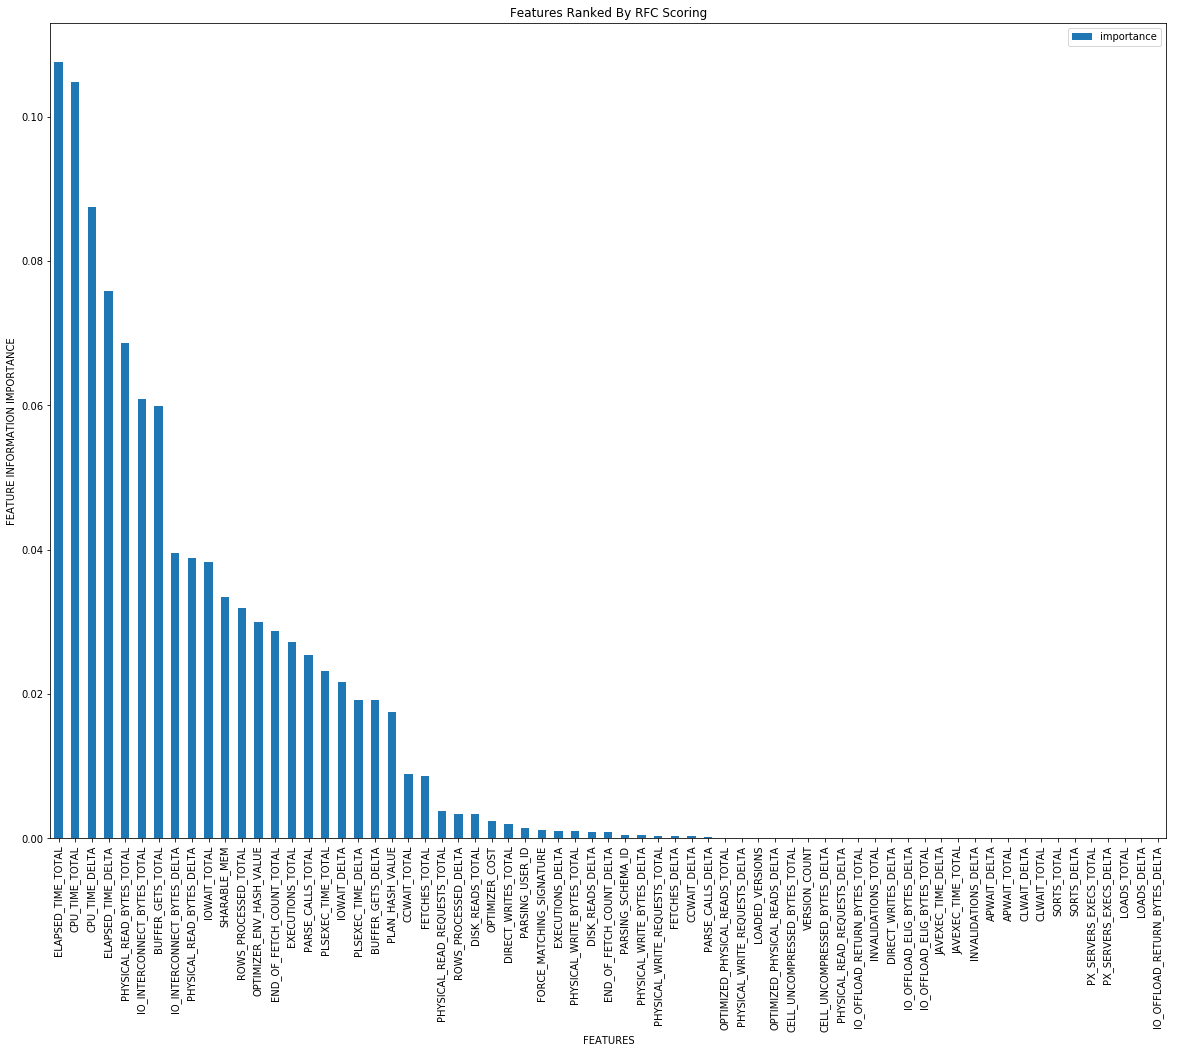

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


                                      importance
feature                                         
REDO GENERATED PER SEC                  0.060996
PHYSICAL WRITE TOTAL BYTES PER SEC      0.053496
PHYSICAL WRITE BYTES PER SEC            0.052867
CONSISTENT READ GETS PER SEC            0.047676
REDO GENERATED PER TXN                  0.044737
CELL PHYSICAL IO INTERCONNECT BYTES     0.039117
PHYSICAL READ TOTAL BYTES PER SEC       0.036903
TEMP SPACE USED                         0.035246
PHYSICAL READ BYTES PER SEC             0.034444
LOGICAL READS PER TXN                   0.033305
ROWS PER SORT                           0.031656
DB BLOCK CHANGES PER SEC                0.031427
TOTAL PGA ALLOCATED                     0.025127
NETWORK TRAFFIC VOLUME PER SEC          0.024816
TXNS PER LOGON                          0.023332
VM IN BYTES PER SEC                     0.022562
PHYSICAL READS PER TXN                  0.021740
LOGICAL READS PER USER CALL             0.019770
LOGICAL READS PER SE

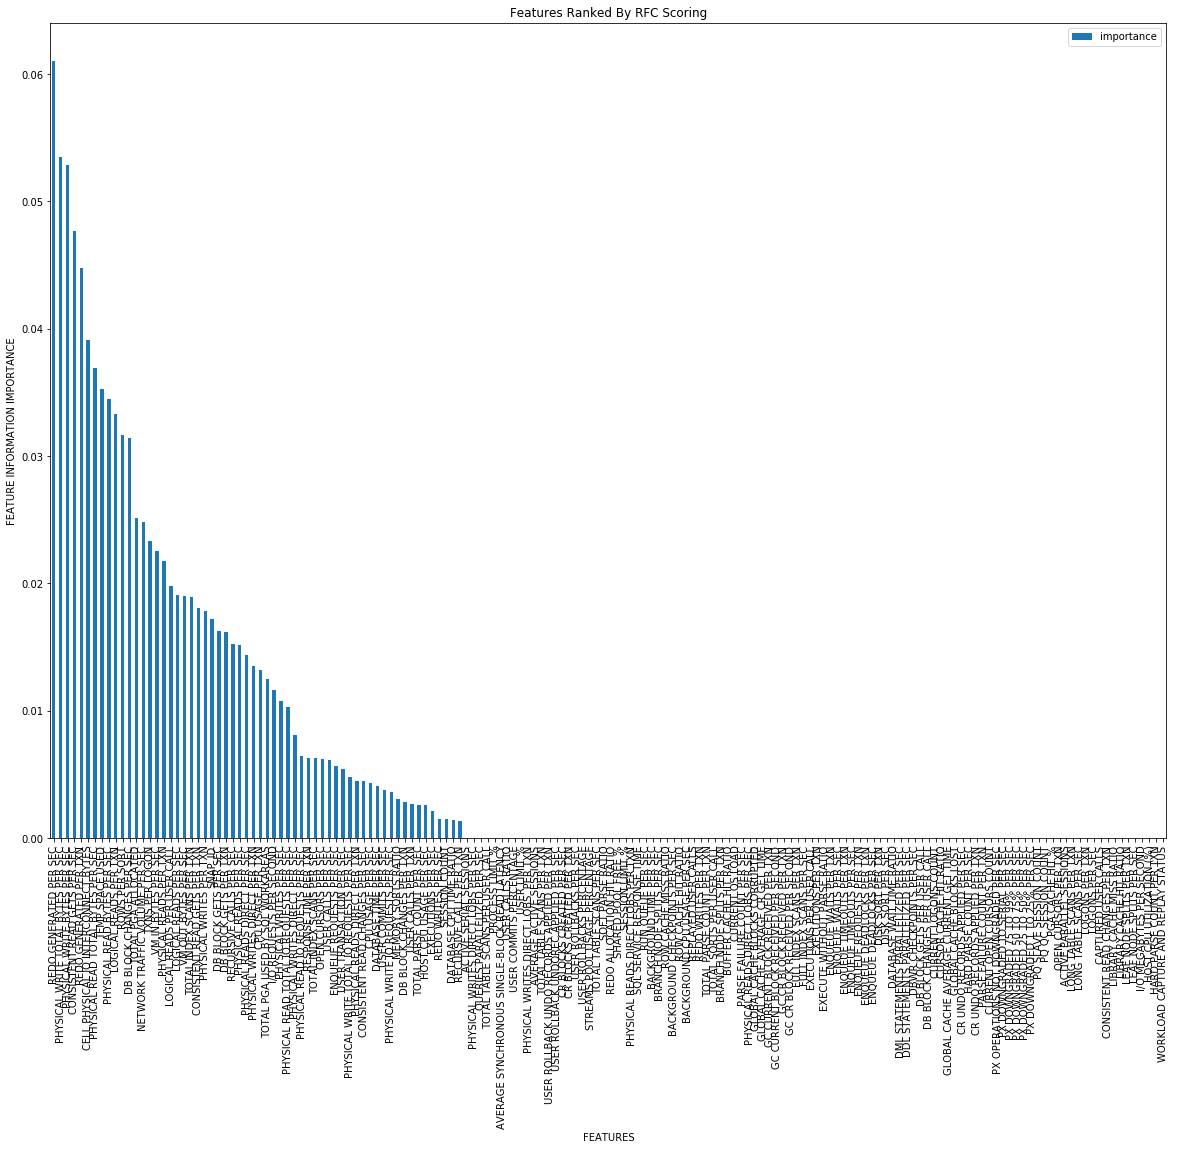

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


                                        importance
feature                                           
PHYSICAL WRITE TOTAL BYTES                0.116207
DB BLOCK GETS                             0.106055
PHYSICAL WRITE BYTES                      0.047136
UNDO CHANGE VECTOR SIZE                   0.042280
NO WORK - CONSISTENT READ GETS            0.040547
REDO BLOCKS WRITTEN                       0.027699
SESSION UGA MEMORY                        0.024470
BYTES RECEIVED VIA SQL*NET FROM CLIENT    0.021859
KTFB ALLOC SPACE (BLOCK)                  0.021261
BUFFER IS NOT PINNED COUNT                0.018110
TABLE SCAN BLOCKS GOTTEN                  0.018057
FILE IO WAIT TIME                         0.016113
TBS EXTENSION: BYTES EXTENDED             0.015593
REDO SYNCH TIME OVERHEAD (USEC)           0.015146
PROCESS LAST NON-IDLE TIME                0.014769
REDO SYNCH TIME (USEC)                    0.014274
CELL PHYSICAL IO INTERCONNECT BYTES       0.014129
IMU UNDO ALLOCATION SIZE       

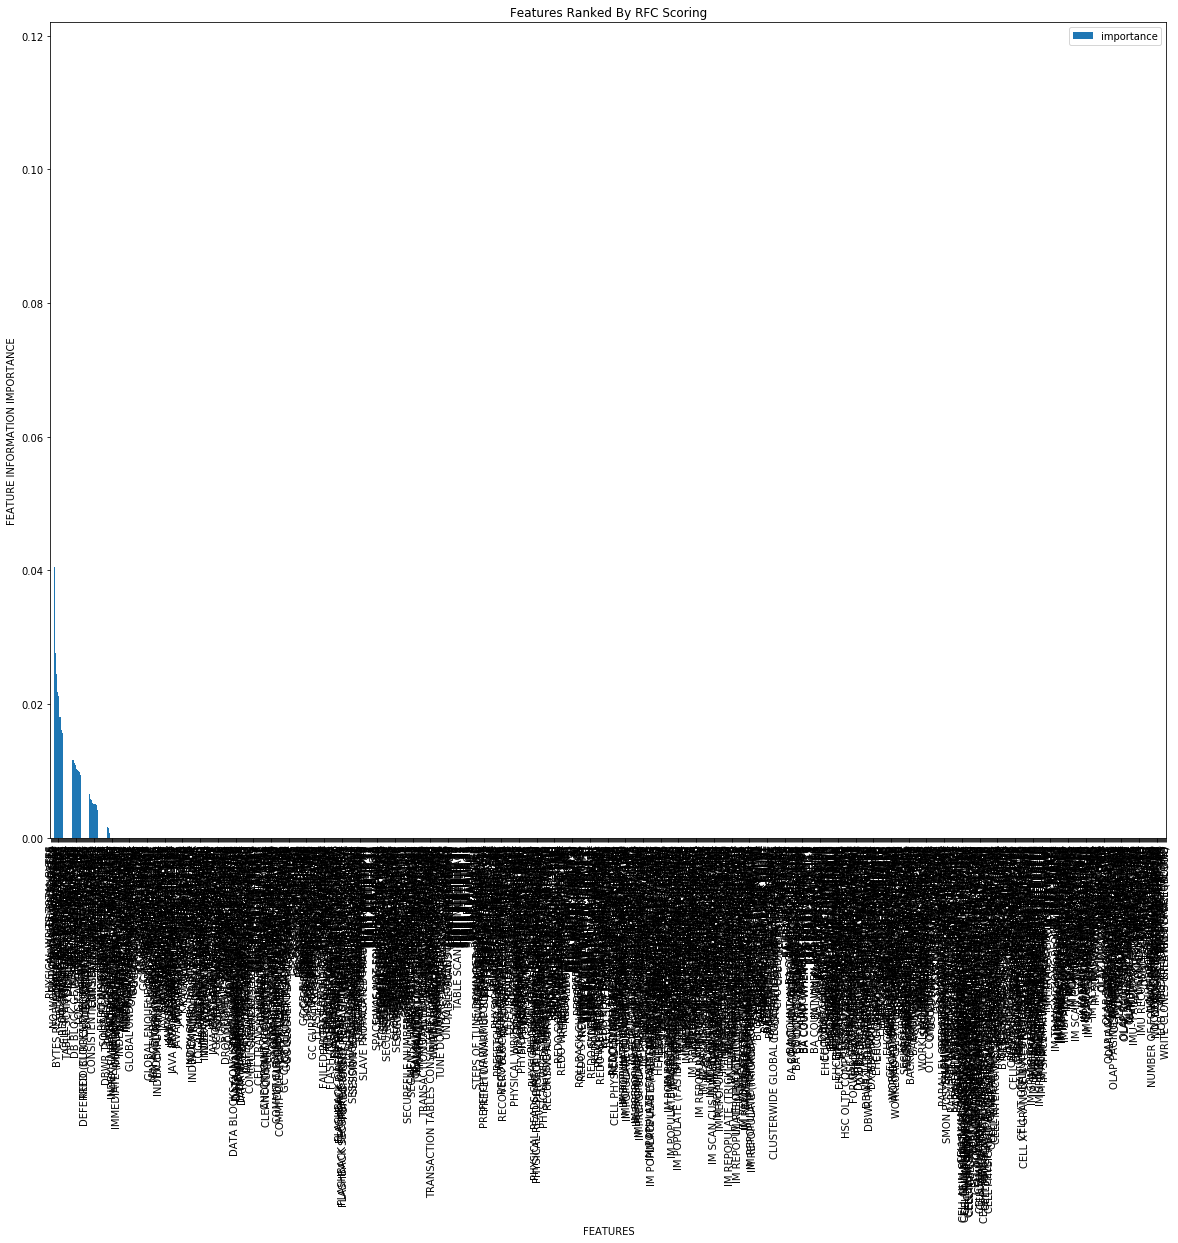

In [161]:
def rfc_ranking(X_df=None, y_df=None, headers=None, top_n_features=20):
    """
    Ranks features using a filter RFC method, and plots them in descending order (ranked by importance)
    """
    rfc = RandomForestClassifier()
    rfc.fit(X_df, y_df)
    importances = pd.DataFrame({'feature':headers,'importance':np.round(rfc.feature_importances_,top_n_features)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature') 
    print(importances)
    importances.plot.bar()
    plt.ylabel('FEATURE INFORMATION IMPORTANCE')
    plt.xlabel('FEATURES')
    plt.title('Features Ranked By RFC Scoring')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
rfc_ranking(X_df=rep_hist_snapshot_df_pruned_norm, 
            y_df=y_rep_hist_snapshot_df_pruned, 
            headers=retain_headers_rep_hist_snapshot)
rfc_ranking(X_df=rep_hist_sysmetric_summary_df_pruned_norm, 
            y_df=y_rep_hist_sysmetric_summary_df_pruned, 
            headers=retain_headers_rep_hist_sysmetric_summary)
rfc_ranking(X_df=rep_hist_sysstat_df_pruned_norm, 
            y_df=y_rep_hist_sysstat_df_pruned, 
            headers=retain_headers_rep_hist_sysstat)